In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import plots
from true_params import true_params
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde, norm
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

## Figure 1

Figure 1 shows the true parameters and also the inferred masses and distances for our data set.

/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_coll

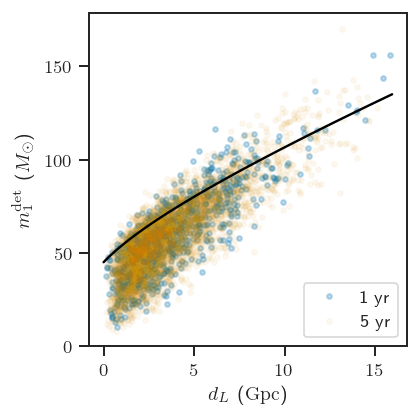

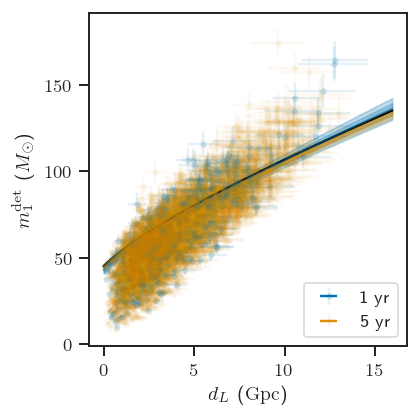

In [3]:
with h5py.File('observations.h5', 'r') as f:
    n1, _ = f.attrs['1yr']
    n1 = int(round(n1))
    m1s = array(f['m1s'])
    zs = array(f['zs'])
    
    m1det = array(f['posteriors/m1det'])
    dl = array(f['posteriors/dl'])
    
with plots.pub_plots(figsize=array(plots.figsize_pub)/2):
    figure()
    d = Planck15.luminosity_distance(zs).to(u.Gpc).value
    plot(d[:n1], m1s[:n1]*(1+zs[:n1]), '.', label='1 yr', color=sns.color_palette()[0], alpha=0.25)
    plot(d[n1:], m1s[n1:]*(1+zs[n1:]), '.', label='5 yr', alpha=0.05, color=sns.color_palette()[1])
    
    z = linspace(0, 2, 100)
    d = Planck15.luminosity_distance(z).to(u.Gpc).value
    
    mmz = true_params['MMax']*(1+z)
    
    plot(d, mmz, color='k')
    
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{det}$ ($M_\odot$)')
    
    l = legend(loc='lower right')
    for lh in l.legendHandles:
        lh.set_alpha(1)
    
    tight_layout()
    savefig('paper/plots/m1-dL-true.pdf')
    
    with h5py.File('paper/plots/m1-dL-true.h5', 'w') as f:
        one = f.create_group('1yr')
        five = f.create_group('5yr')
        
        one.create_dataset('dL', data=d[:n1], compression='gzip', shuffle=True)
        one.create_dataset('m1det', data=m1s[:n1]*(1+zs[:n1]), compression='gzip', shuffle=True)
        
        five.create_dataset('dL', data=d[n1:], compression='gzip', shuffle=True)
        five.create_dataset('m1det', data=m1s[n1:]*(1+zs[n1:]), compression='gzip', shuffle=True)
        
        f.create_dataset('dL', data=d, compression='gzip', shuffle=True)
        f.create_dataset('m1_turnoff', data=mmz, compression='gzip', shuffle=True)
        
    figure()
    
    dm = mean(dl, axis=1)
    ds = std(dl, axis=1)
    mm = mean(m1det, axis=1)
    ms = std(m1det, axis=1)
    
    errorbar(dm[:n1], mm[:n1], xerr=ds[:n1], yerr=ms[:n1], fmt='.', label='1 yr', color=sns.color_palette()[0], alpha=0.1)
    errorbar(dm[n1:], mm[n1:], xerr=ds[n1:], yerr=ms[n1:], fmt='.', label='5 yr', color=sns.color_palette()[1], alpha=0.05)
    
    plot(d, mmz, color='k')
    
    c1 = az.from_netcdf('population_1yr_32768.nc')
    H0 = c1.posterior.H0.values.flatten()
    MMax = c1.posterior.MMax.values.flatten()
    Om = c1.posterior.Om.values.flatten()
    w0 = c1.posterior.w0.values.flatten()
        
    z = linspace(0, 10, 250)
    mmzs1 = []
    for h, M, O, w in zip(H0, MMax, Om, w0):
        c = cosmo.FlatwCDM(h*u.km/u.s/u.Mpc, O, w)
        dd = c.luminosity_distance(z).to(u.Gpc).value
        zs = interp1d(dd, z)(d)
        mmzs1.append(M*(1+zs))
    mmzs1 = array(mmzs1)
    
    plot(d, median(mmzs1, axis=0), color=sns.color_palette()[0], alpha=0.5)
    fill_between(d, percentile(mmzs1, 84, axis=0), percentile(mmzs1, 16, axis=0), alpha=0.25, color=sns.color_palette()[0])
    fill_between(d, percentile(mmzs1, 97.5, axis=0), percentile(mmzs1, 2.5, axis=0), alpha=0.25, color=sns.color_palette()[0])
    
    c5 = az.from_netcdf('population_5yr_131072.nc')
    H0 = c5.posterior.H0.values.flatten()
    MMax = c5.posterior.MMax.values.flatten()
    Om = c5.posterior.Om.values.flatten()
    w0 = c5.posterior.w0.values.flatten()

    z = linspace(0, 10, 250)
    mmzs5 = []
    for h, M, O, w in zip(H0, MMax, Om, w0):
        c = cosmo.FlatwCDM(h, O, w)
        dd = c.luminosity_distance(z).to(u.Gpc).value
        zs = interp1d(dd, z)(d)
        mmzs5.append(M*(1+zs))
    mmzs5 = array(mmzs5)
    
    plot(d, median(mmzs5, axis=0), alpha=0.5, color=sns.color_palette()[1])
    fill_between(d, percentile(mmzs5, 84, axis=0), percentile(mmzs5, 16, axis=0), alpha=0.25, color=sns.color_palette()[1])
    fill_between(d, percentile(mmzs5, 97.5, axis=0), percentile(mmzs5, 2.5, axis=0), alpha=0.25, color=sns.color_palette()[1])
    
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{det}$ ($M_\odot$)')
    
    l = legend(loc='lower right')
    for lh in l.legendHandles:
        lh.set_alpha(1)
        
    tight_layout()
    
    savefig('paper/plots/m1-dL-obs.pdf')
    
    with h5py.File('paper/plots/m1-dL-obs.h5', 'w') as f:
        one = f.create_group('1yr')
        five = f.create_group('5yr')
        
        one.create_dataset('dL', data=dm[:n1], compression='gzip', shuffle=True)
        one.create_dataset('dl_err', data=ds[:n1], compression='gzip', shuffle=True)
        one.create_dataset('m1det', data=mm[:n1], compression='gzip', shuffle=True)
        one.create_dataset('m1det_err', data=ms[:n1], compression='gzip', shuffle=True)
        
        five.create_dataset('dL', data=dm[n1:], compression='gzip', shuffle=True)
        five.create_dataset('dl_err', data=ds[n1:], compression='gzip', shuffle=True)
        five.create_dataset('m1det', data=mm[n1:], compression='gzip', shuffle=True)
        five.create_dataset('m1det_err', data=ms[n1:], compression='gzip', shuffle=True)
        
        f.create_dataset('dL', data=d, compression='gzip', shuffle=True)
        f.create_dataset('m1_cutoff', data=mmz, compression='gzip', shuffle=True)
        f.create_dataset('m1_cutoff_1yr', data=mmzs1, compression='gzip', shuffle=True)
        f.create_dataset('m1_cutoff_5yr', data=mmzs5, compression='gzip', shuffle=True)

## Figure 2

Figure 2 shows the constraints we obtain on $H(z)$.

Redshift at which 1-sigma fractional H(z) interval min of 0.061 is 0.71
Redshift at which 1-sigma fractional H(z) interval min of 0.028 is 0.72


/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_coll

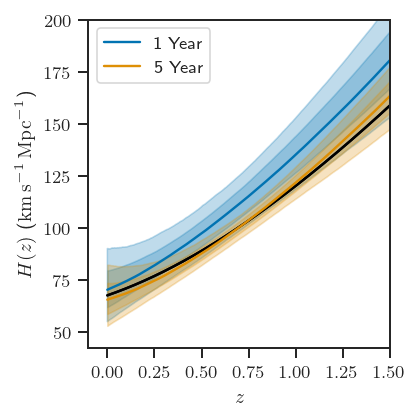

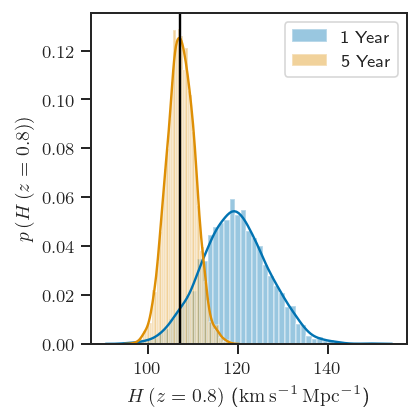

In [41]:
c = az.from_netcdf('population_1yr_32768.nc')
cc = az.from_netcdf('population_5yr_131072.nc')

with plots.pub_plots(figsize=array(plots.figsize_pub)/2):
    figure()
    
    zs, Hs1 = plots.Hz_plot(c, draw_tracks=False, label='1 Year')
    
    _, Hs5 = plots.Hz_plot(cc, color=sns.color_palette()[1], draw_tracks=False, label=r'5 Year')
    
    legend(loc='upper left')
    
    axis(xmax=1.5, ymax=200)
    
    xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
    
    tight_layout()
    savefig('paper/plots/Hz.pdf')
    
    with h5py.File('paper/plots/Hz.h5', 'w') as f:
        f.create_dataset('zs', data=zs, compression='gzip', shuffle=True)
        f.create_dataset('Hs-1yr', data=Hs1, compression='gzip', shuffle=True)
        f.create_dataset('Hs-5yr', data=Hs5, compression='gzip', shuffle=True)
        
    figure()
    i = argmin(abs(zs-0.8))
    
    H8_1 = array([cosmo.FlatwCDM(H0*u.km/u.s/u.Mpc, Om, w).efunc(0.8)*H0 for H0, Om, w in zip(c.posterior.H0.values.flatten(), c.posterior.Om.values.flatten(), c.posterior.w0.values.flatten())])
    H8_5 = array([cosmo.FlatwCDM(H0*u.km/u.s/u.Mpc, Om, w).efunc(0.8)*H0 for H0, Om, w in zip(cc.posterior.H0.values.flatten(), cc.posterior.Om.values.flatten(), cc.posterior.w0.values.flatten())])
    
    sns.distplot(H8_1.flatten(), label='1 Year')
    sns.distplot(H8_5.flatten(), label='5 Year')
    
    xlabel(r'$H\left( z = 0.8 \right)$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( H\left( z = 0.8 \right) \right)$')
    
    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value*Planck15.efunc(0.8), color='k')
    
    legend(loc='best')
    
    tight_layout()
    savefig('paper/plots/H08.pdf')
    
    with h5py.File('paper/plots/H08.h5', 'w') as f:
        f.create_dataset('H08_1yr', data=H8_1.flatten(), compression='gzip', shuffle=True)
        f.create_dataset('H08_5yr', data=H8_5.flatten(), compression='gzip', shuffle=True)

## Figure 3

Figure 3 will show how the masses are corrected to find the redshift.

/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_coll

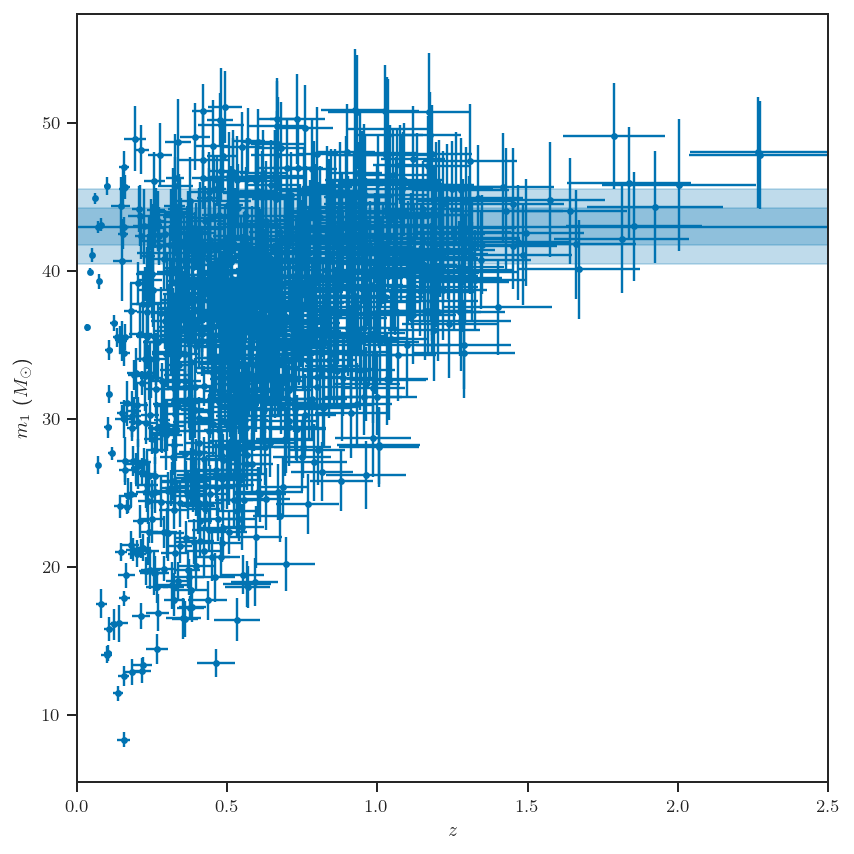

In [5]:
with plots.pub_plots():
    c = az.from_netcdf('population_1yr_32768.nc')
    plots.mass_correction_plot(c)
    axis(xmin=0, xmax=2.5)
    
    tight_layout()
    
    savefig('paper/plots/mass-correction.pdf')
    
    with h5py.File('paper/plots/mass-correction.h5', 'w') as f:
        f.attrs['MMax_median'] = median(c.posterior.MMax.values)
        f.attrs['MMax_2.5'] = percentile(c.posterior.MMax.values, 2.5)
        f.attrs['MMax_16'] = percentile(c.posterior.MMax.values, 16)
        f.attrs['MMax_84'] = percentile(c.posterior.MMax.values, 84)
        f.attrs['MMax_97.5'] = percentile(c.posterior.MMax.values, 97.5)
        
        f.create_dataset('m1_mean', data=np.mean(c.posterior.m1s.values, axis=(0,1)), compression='gzip', shuffle=True)
        f.create_dataset('m1_std', data=np.std(c.posterior.m1s.values, axis=(0,1)), compression='gzip', shuffle=True)
        
        f.create_dataset('z_mean', data=np.mean(c.posterior.zs.values, axis=(0,1)), compression='gzip', shuffle=True)
        f.create_dataset('z_std', data=np.std(c.posterior.zs.values, axis=(0,1)), compression='gzip', shuffle=True)

## Figure 4

Figure 4 shows the constraints we obtain on pure dark-energy models with a fixed equation of state, incorporating other constraints on $H_0$ and $\Omega_M$.

We need the below call *before* the cell is evaluated to make the axes labels work out OK.

In [6]:
plt.rcParams['axes.unicode_minus'] = False

/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_coll

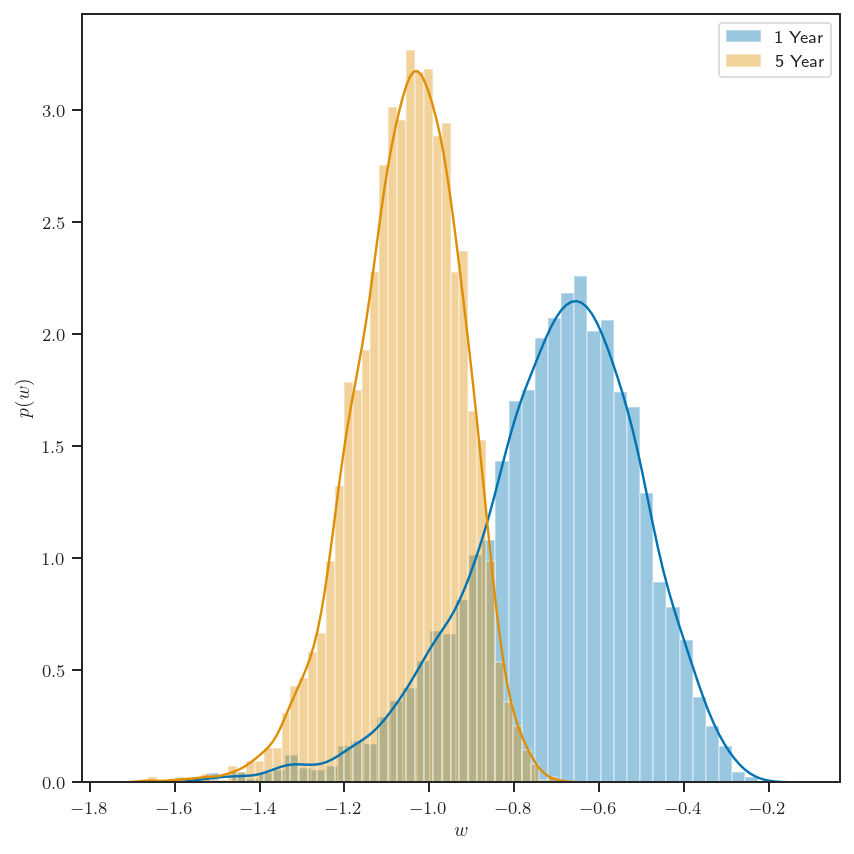

In [42]:
c = az.from_netcdf('population_1yr_cosmo_32768.nc')
cc = az.from_netcdf('population_5yr_cosmo_131072.nc')

w1 = c.posterior.w0.values.flatten()
w5 = cc.posterior.w0.values.flatten()

with plots.pub_plots():
    sns.distplot(w1, label='1 Year')
    
    sns.distplot(w5, label='5 Year')

    legend(loc='best')
    
    xlabel(r'$w$')
    ylabel(r'$p(w)$')
    
    tight_layout()
    savefig('paper/plots/wDE.pdf')
    
    with h5py.File('paper/plots/wDE.h5', 'w') as f:
        f.create_dataset('wDE_1yr', data=w1, compression='gzip', shuffle=True)
        f.create_dataset('wDE_5yr', data=w5, compression='gzip', shuffle=True)

## Macros

In [38]:
with h5py.File('observations.h5', 'r') as f:
    n1, _ = f.attrs['1yr']
    n1 = int(round(n1))
    m1s = array(f['m1s'])
    zs = array(f['zs'])
    
    m1det = array(f['posteriors/m1det'])
    dl = array(f['posteriors/dl'])
    
fit1 = az.from_netcdf('population_1yr_32768.nc')
fit5 = az.from_netcdf('population_5yr_131072.nc')
fit1_cosmo = az.from_netcdf('population_1yr_cosmo_32768.nc')
fit5_cosmo = az.from_netcdf('population_5yr_cosmo_131072.nc')

print('Median detected redshift is {:.1f}'.format(median(zs)))

Median detected redshift is 0.5


In [10]:
def one_sigma_values(xs):
    m = median(xs)
    l = percentile(xs, 16)
    h = percentile(xs, 84)
    
    return (m, h-m, m-l)

def one_sigma_range(xs):
    l = percentile(xs, 16)
    h = percentile(xs, 84)
    
    return (l, h)

In [23]:
def sigma_rel_H_min(fit):
    H0s = fit.posterior.H0.values.flatten()
    Oms = fit.posterior.Om.values.flatten()
    ws = fit.posterior.w0.values.flatten()
    
    zs = linspace(0, 2, 1024)
    
    mu_Hz = H0s[0]*cosmo.FlatwCDM(H0s[0]*u.km/u.s/u.Mpc, Oms[0], ws[0]).efunc(zs)
    m2_Hz = zeros_like(mu_Hz)
    n = 1
    
    for H0, Om, w in zip(H0s[1:], Oms[1:], ws[1:]):
        Hz = H0*cosmo.FlatwCDM(H0*u.km/u.s/u.Mpc, Om, w).efunc(zs)
        
        n += 1
        delta = Hz - mu_Hz
        mu_Hz = mu_Hz + delta/n
        m2_Hz = m2_Hz + (Hz - mu_Hz)*delta
        
    sigma_Hz = sqrt(m2_Hz / n)
    
    sigma_Hz_rel = sigma_Hz / mu_Hz
    
    imin = argmin(sigma_Hz_rel)
    
    return zs[imin], sigma_Hz_rel[imin]

In [27]:
zmin1, sigma_min1 = sigma_rel_H_min(fit1)
zmin5, sigma_min5 = sigma_rel_H_min(fit5)

zmin1, sigma_min1, zmin5, sigma_min5

(0.678396871945259,
 0.061339492133083415,
 0.7663734115347018,
 0.02881253345832143)

In [40]:
print(r'\newcommand{{\MScaleOneYear}}{{{:.1f}^{{+{:.1f}}}_{{-{:.1f}}} \, \MSun{{}}}}'.format(*one_sigma_values(fit1.posterior.MMax.values)))
print(r'\newcommand{{\MScaleFiveYear}}{{{:.2f}^{{+{:.2f}}}_{{-{:.2f}}} \, \MSun{{}}}}'.format(*one_sigma_values(fit5.posterior.MMax.values)))
print(r'\newcommand{{\SigmaHPvtOneYear}}{{{:.1f} \%}}'.format(100*sigma_min1))
print(r'\newcommand{{\SigmaHPvtFiveYear}}{{{:.1f} \%}}'.format(100*sigma_min5))
print(r'\newcommand{{\SigmaHNaughtTransFiveYear}}{{{:.1f}}}'.format(70*sigma_min5))
print(r'\newcommand{{\zpivot}}{{{:.1f}}}'.format(zmin5))
print(r'\newcommand{{\wDEOneYear}}{{{:.2f}^{{+{:.2f}}}_{{{:.2f}}}}}'.format(*one_sigma_values(fit1_cosmo.posterior.w0.values)))
print(r'\newcommand{{\wDEFiveYear}}{{{:.2f}^{{+{:.2f}}}_{{{:.2f}}}}}'.format(*one_sigma_values(fit5_cosmo.posterior.w0.values)))
print(r'\newcommand{{\SigmawDEOneYear}}{{{:.0f} \%}}'.format(100*std(fit1_cosmo.posterior.w0.values)/abs(mean(fit5_cosmo.posterior.w0.values))))
print(r'\newcommand{{\SigmawDEFiveYear}}{{{:.0f} \%}}'.format(100*std(fit5_cosmo.posterior.w0.values)/abs(mean(fit5_cosmo.posterior.w0.values))))

\newcommand{\MScaleOneYear}{43.0^{+1.3}_{-1.3} \, \MSun{}}
\newcommand{\MScaleFiveYear}{44.64^{+0.76}_{-0.81} \, \MSun{}}
\newcommand{\SigmaHPvtOneYear}{6.1 \%}
\newcommand{\SigmaHPvtFiveYear}{2.9 \%}
\newcommand{\SigmaH0TransFiveYear}{2.0}
\newcommand{\zpivot}{0.8}
\newcommand{\wDEOneYear}{-0.68^{+0.17}_{0.21}}
\newcommand{\wDEFiveYear}{-1.04^{+0.12}_{0.13}}
\newcommand{\SigmawDEOneYear}{19 \%}
\newcommand{\SigmawDEFiveYear}{12 \%}


## Methods Figure 1

/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/wfarr/anaconda3/envs/PISN/lib/python3.7/_coll

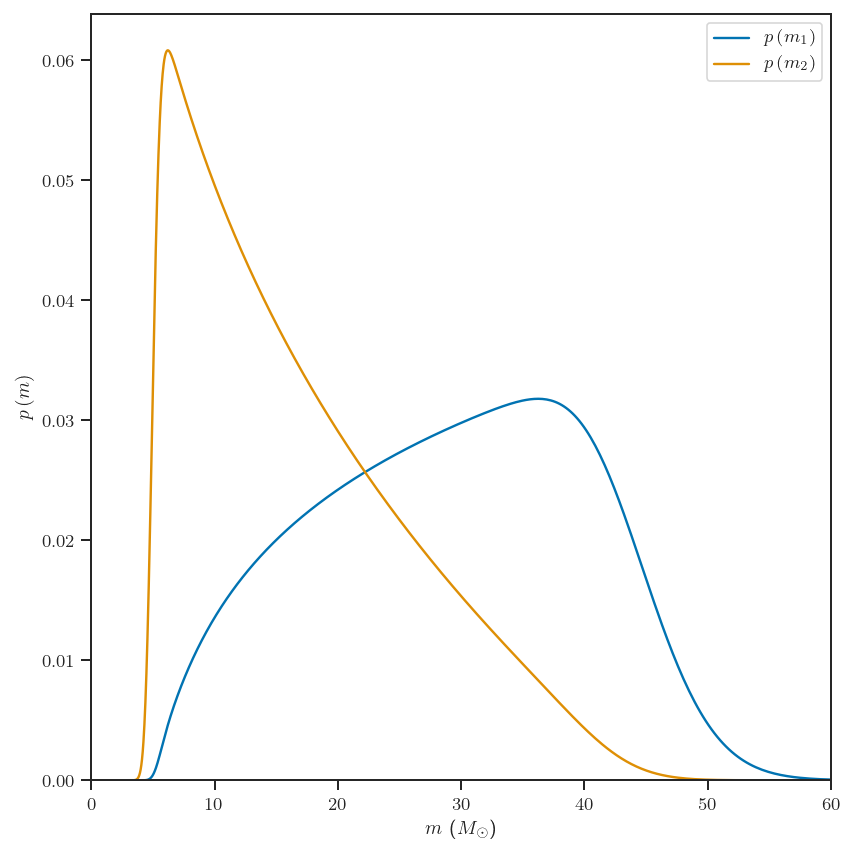

In [13]:
def fsmooth(m, ml, sl, mh, sh):
    return norm(loc=log(ml), scale=sl).cdf(log(m))*(1-norm(loc=log(mh), scale=sh).cdf(log(m)))
def pms_unnorm(m1, m2):
    return (m1/30)**(-true_params['alpha'])*(m2/30)**(true_params['beta'])*fsmooth(m1, true_params['MMin'], true_params['smooth_min'], true_params['MMax'], true_params['smooth_max'])*fsmooth(m2, true_params['MMin'], true_params['smooth_min'], true_params['MMax'], true_params['smooth_max'])

ms = exp(linspace(log(1), log(100), 1000))
M1S, M2S = meshgrid(ms, ms, indexing='ij')
PS = np.where(M2S <= M1S, pms_unnorm(M1S, M2S), 0)

pm1 = trapz(PS, M2S, axis=1)
pm2 = trapz(PS, M1S, axis=0)

pm1 /= trapz(pm1, ms)
pm2 /= trapz(pm2, ms)

PS /= trapz(trapz(PS, M2S, axis=1), ms, axis=0)

with plots.pub_plots(figsize=plots.figsize_pub):
    plot(ms, pm1, label=r'$p\left( m_1 \right)$')
    plot(ms, pm2, label=r'$p\left( m_2 \right)$')
    
    axis(xmin=0, xmax=60, ymin=0)
    
    xlabel(r'$m$ ($M_\odot$)')
    ylabel(r'$p\left( m \right)$')
    
    legend(loc='best')
    
    tight_layout()
    
    savefig('paper/plots/pm1m2-marg.pdf')
    
    with h5py.File('paper/plots/pm1m2.h5', 'w') as f:
        f.create_dataset('ms', data=ms, compression='gzip', shuffle=True)
        f.create_dataset('pm1', data=pm1, compression='gzip', shuffle=True)
        f.create_dataset('pm2', data=pm2, compression='gzip', shuffle=True)
        f.create_dataset('pm1m2', data=PS, compression='gzip', shuffle=True)